In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/online-retail-ii-uci/online_retail_II.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import linregress,stats
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from prophet import Prophet
import statsmodels.api as sm
from sklearn.metrics import r2_score,mean_squared_error

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df=pd.read_csv('/kaggle/input/online-retail-ii-uci/online_retail_II.csv')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
df2=df.copy()
df2.head() #ilk 5 satırı görelim

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
"""
Attribute Information:

InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
Description: Product (item) name. Nominal.
Quantity: The quantities of each product (item) per transaction. Numeric.
InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated.
UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£).
CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
Country: Country name. Nominal. The name of the country where a customer resides.
"""

"\nAttribute Information:\n\nInvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.\nStockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.\nDescription: Product (item) name. Nominal.\nQuantity: The quantities of each product (item) per transaction. Numeric.\nInvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated.\nUnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£).\nCustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.\nCountry: Country name. Nominal. The name of the country where a customer resides.\n"

In [5]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [6]:
# Invoice sütununda sadece rakamlardan oluşmayan değerlere sahip satırları filtreleyin ve silin
df2 = df2[df2['Invoice'].str.isdigit()]
# Invoice sütununun uzunluğu 6 olmayan satırları filtreleyin ve silin
df2 = df2[df2['Invoice'].str.len() == 6]
# StockCode sütununda sadece rakamlardan oluşmayan değerlere sahip satırları filtreleyin ve silin
df2 = df2[df2['StockCode'].str.isdigit()]
# StockCode sütununun uzunluğu 5 olmayan satırları filtreleyin ve silin
df2 = df2[df2['StockCode'].str.len() == 5]
#Price ve Quantity 0'dan büyük olamaz
df2=df2[df2['Price'] > 0]
df2=df2[df2['Quantity'] > 0]
df2['Total Price']=df2['Quantity']*df2['Price']
# InvoiceDate sütununu datetime tipine dönüştürme
df2["InvoiceDate"] = pd.to_datetime(df2["InvoiceDate"])
# Year adında yeni bir sütun oluşturup yılları yazma
df2["Year"] = df2["InvoiceDate"].dt.year
# Month adında yeni bir sütun oluşturup ayları yazma
df2["Month"] = df2["InvoiceDate"].dt.month
# Day adında yeni bir sütun oluşturup günleri yazma
df2["Day"] = df2["InvoiceDate"].dt.day
# InvoiceDate sütununu silme
df2 = df2.drop("InvoiceDate", axis=1)


In [7]:
df2.reset_index(drop=True)

,Invoice,StockCode,Description,Quantity,Price,Customer ID,Country,Total Price,Year,Month,Day
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,6.95,13085.0,United Kingdom,83.40,2009,12,1
1,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2.10,13085.0,United Kingdom,100.80,2009,12,1
2,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,1.25,13085.0,United Kingdom,30.00,2009,12,1
3,489434,22064,PINK DOUGHNUT TRINKET POT,24,1.65,13085.0,United Kingdom,39.60,2009,12,1
4,489434,21871,SAVE THE PLANET MUG,24,1.25,13085.0,United Kingdom,30.00,2009,12,1
...,...,...,...,...,...,...,...,...,...,...,...
911973,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,0.85,12680.0,France,10.20,2011,12,9
911974,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2.10,12680.0,France,12.60,2011,12,9
911975,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,4.15,12680.0,France,16.60,2011,12,9
911976,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,4.15,12680.0,France,16.60,2011,12,9


In [8]:
df2.isnull().sum()/len(df2)

Invoice        0.000000
StockCode      0.000000
Description    0.000000
Quantity       0.000000
Price          0.000000
Customer ID    0.217098
Country        0.000000
Total Price    0.000000
Year           0.000000
Month          0.000000
Day            0.000000
dtype: float64

In [9]:
#Customer ID'si boş olan satırlardaki Invoicelar ile Customer ID'si dolu olan satırlardaki Invoicelerdan aynı olan var mı?
liste_customer_id_dolu_invoice=[]
x=df2[df2['Invoice'].notnull() & df2['Customer ID'].notnull()]
liste_customer_id_dolu_invoice=x['Invoice'].unique()

liste_customer_id_bos_invoice=[]
y=df2[df2['Invoice'].notnull() & df2['Customer ID'].isnull()]
liste_customer_id_bos_invoice=y['Invoice'].unique()

ortak_elemanlar = []
for eleman in liste_customer_id_dolu_invoice:
    if eleman in liste_customer_id_bos_invoice:
        ortak_elemanlar.append(eleman)

print("Ortak elemanlar:", ortak_elemanlar)

Ortak elemanlar: []


In [10]:
# Eksik (NaN) Customer ID'leri içeren satırları silelim
df2.dropna(axis=0,inplace=True)
df2.reset_index(drop=True,inplace=True)
# Float'tan int'e dönüştürelim
df2['Customer ID'] = df2['Customer ID'].astype(int)
# İnt'ten string'e dönüştürelim
df2['Customer ID'] = df2['Customer ID'].astype(str)

In [11]:
df2[(df2['StockCode']=='10002') & (df2['Country']=='France')&(df2['Customer ID']=='12583')
   &(df2['Month']==12) &(df2['Day']==1) ] #tekrar eden satır örneği
#Fransadaki aynı müşteri aynı ay ve günde aynı üründen ve aynı miktardan alışveriş yapmış.
#Tekrar eden satırları silelim.

,Invoice,StockCode,Description,Quantity,Price,Customer ID,Country,Total Price,Year,Month,Day
338025,536370,10002,INFLATABLE POLITICAL GLOBE,48,0.85,12583,France,40.8,2010,12,1
350929,536370,10002,INFLATABLE POLITICAL GLOBE,48,0.85,12583,France,40.8,2010,12,1


In [12]:
# Tekrar eden satırları silelim
df2.drop_duplicates(inplace=True)
df2.reset_index(drop=True,inplace=True)
#Veriler daha düzenli olsun
df2 = df2.sort_values(by=['Country','Year','Month','StockCode'])
df2.reset_index(drop=True,inplace=True)

In [13]:
len(df2)

690586

In [14]:
round(df2.describe([0.05,0.25,0.50,0.75,0.85,0.95,0.99,0.995,0.999]),3)

,Quantity,Price,Total Price,Year,Month,Day
count,690586.000,690586.000,690586.000,690586.000,690586.000,690586.000
mean,13.592,2.937,21.760,2010.451,7.471,15.426
std,153.298,4.411,237.906,0.563,3.394,8.662
min,1.000,0.030,0.060,2009.000,1.000,1.000
5%,1.000,0.420,1.260,2010.000,1.000,2.000
25%,2.000,1.250,4.950,2010.000,5.000,8.000
50%,6.000,1.950,12.500,2010.000,8.000,15.000
75%,12.000,3.750,19.800,2011.000,11.000,23.000
85%,18.000,4.950,26.400,2011.000,11.000,26.000
95%,39.750,8.500,65.700,2011.000,12.000,29.000


In [15]:
#Quantity değişkeninin ortna 2 std sapma ekleyelim. Bunu yapmamın nedeni ort ile std sapma arasında büyük bir fark olduuğudur.
df2['Quantity'].mean()+2*df2['Quantity'].std()

320.18915353796075

In [16]:
len(df2[df2["Quantity"] >320]) #Quantity'si 320den büyük olan satır sayısı

1623

In [17]:
#Quantity'si 320 den büyük olan satırları silelim
df2 = df2[df2["Quantity"] < 320]
df2.reset_index(drop=True,inplace=True)

In [18]:
round(df2.describe([0.05,0.25,0.50,0.75,0.85,0.95,0.99,0.995,0.999]),3)

,Quantity,Price,Total Price,Year,Month,Day
count,688929.000,688929.000,688929.000,688929.000,688929.000,688929.000
mean,11.334,2.941,19.894,2010.451,7.472,15.426
std,22.518,4.415,65.210,0.563,3.394,8.662
min,1.000,0.040,0.060,2009.000,1.000,1.000
5%,1.000,0.420,1.260,2010.000,1.000,2.000
25%,2.000,1.250,4.950,2010.000,5.000,8.000
50%,6.000,1.950,12.500,2010.000,8.000,15.000
75%,12.000,3.750,19.740,2011.000,11.000,23.000
85%,17.000,4.950,25.500,2011.000,11.000,26.000
95%,36.000,8.500,62.400,2011.000,12.000,29.000


In [19]:
df2['Total Price'].mean()+1*df2['Total Price'].std()

85.10446109730937

In [20]:
#Total Price'ı 85 den büyük olan satırları silelim
df2 = df2[df2["Total Price"] < 85]
df2.reset_index(drop=True,inplace=True)

In [21]:
(690586-len(df2))/690586 #Toplam aykırı değerlerin başta tüm gözlem değerlerine oranı

0.03395522063870394

In [22]:
round(df2.describe([0.05,0.25,0.50,0.75,0.85,0.95,0.99,0.995,0.999]),3) 

,Quantity,Price,Total Price,Year,Month,Day
count,667137.000,667137.000,667137.000,667137.000,667137.000,667137.000
mean,9.019,2.859,14.409,2010.451,7.477,15.434
std,13.855,3.005,13.691,0.563,3.393,8.669
min,1.000,0.040,0.060,2009.000,1.000,1.000
5%,1.000,0.420,1.250,2010.000,1.000,2.000
25%,2.000,1.250,4.950,2010.000,5.000,8.000
50%,5.000,1.850,11.700,2010.000,8.000,15.000
75%,12.000,3.750,17.700,2011.000,11.000,23.000
85%,12.000,4.950,23.400,2011.000,11.000,26.000
95%,25.000,8.500,40.800,2011.000,12.000,29.000


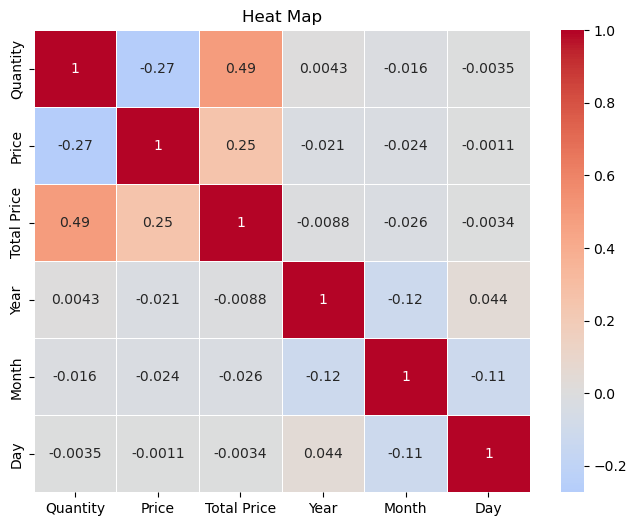

In [23]:
# Isı haritası için ilgili sütunları seçelim (örneğin, "RESIDENTIAL UNITS", "COMMERCIAL UNITS" ve "TOTAL UNITS" gibi)
heat_map_data = df2[['Quantity','Price','Total Price','Year','Month','Day']]

# Korelasyon matrisini hesaplayalım
correlation_matrix = heat_map_data.corr()

# Isı haritasını çizelim
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Heat Map")
plt.show()

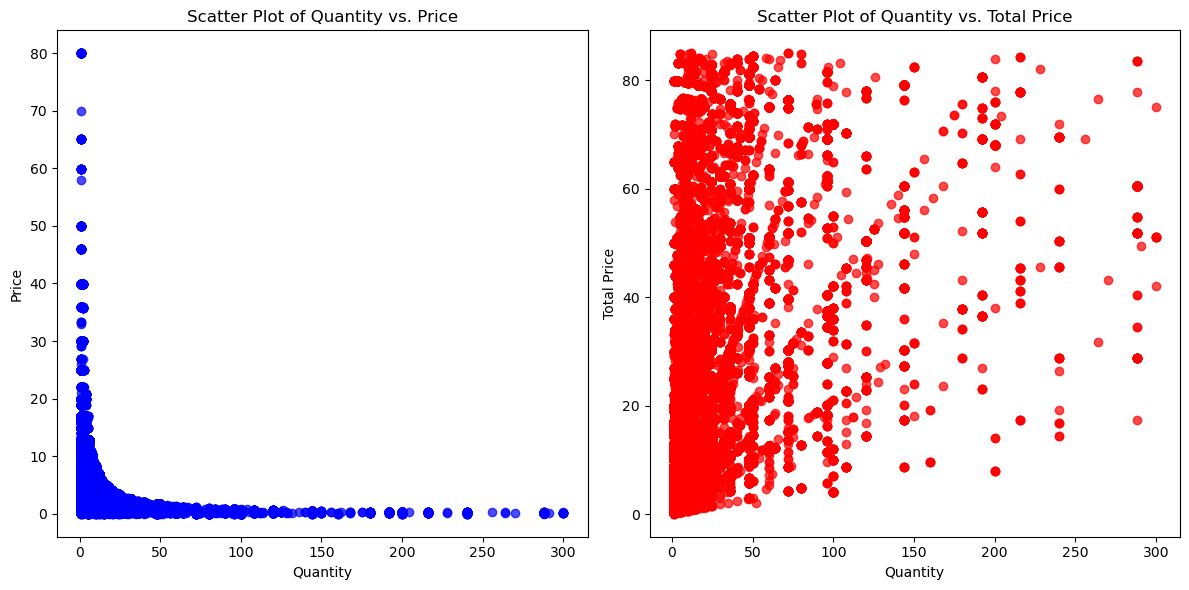

In [24]:
# İki saçılım grafiği için subplotlar oluşturalım
plt.figure(figsize=(12, 6))

# İlk saçılım grafiği
plt.subplot(1, 2, 1)
plt.scatter(df2['Quantity'], df2['Price'], marker='o', color='b', alpha=0.7)
plt.xlabel('Quantity')
plt.ylabel('Price')
plt.title('Scatter Plot of Quantity vs. Price')

# İkinci saçılım grafiği
plt.subplot(1, 2, 2)
plt.scatter(df2['Quantity'], df2['Total Price'], marker='o', color='r', alpha=0.7)
plt.xlabel('Quantity')
plt.ylabel('Total Price')
plt.title('Scatter Plot of Quantity vs. Total Price')

plt.tight_layout()
plt.show()

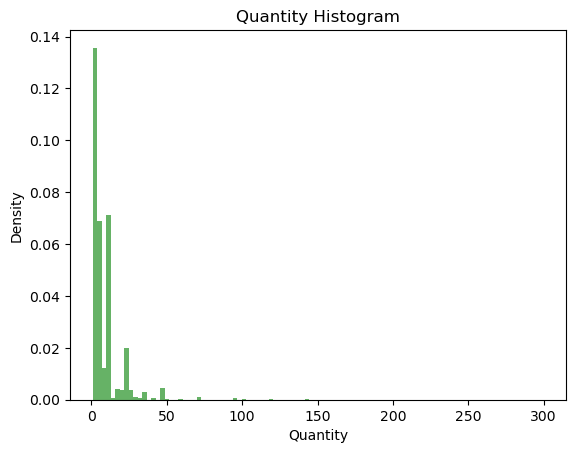

In [25]:
# Quantity'nin histogramı
n_bins = 100 
plt.hist(df2['Quantity'], bins=n_bins, density=True, alpha=0.6, color='g')  # density=True, yoğunluk grafiğini gösterir.

# Grafiği düzenleyin
plt.xlabel('Quantity')
plt.ylabel('Density')
plt.title('Quantity Histogram')

# Grafiği gösterdiğimizde sağa çarpık dağılıma sahip olduğunu görürüz
plt.show()


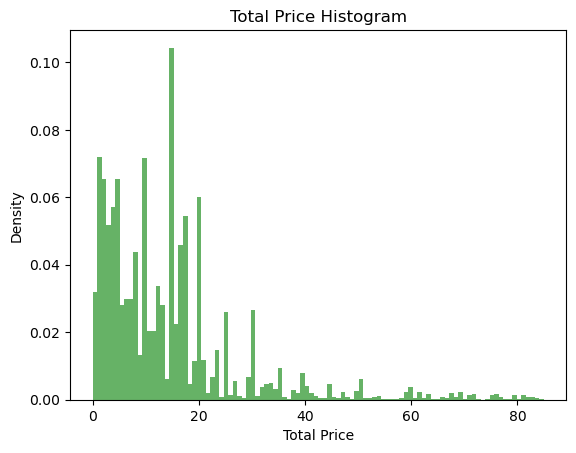

In [26]:
# Total Price'in histogramı
n_bins = 100 
plt.hist(df2['Total Price'], bins=n_bins, density=True, alpha=0.6, color='g')  # density=True, yoğunluk grafiğini gösterir.

# Grafiği düzenleyelim
plt.xlabel('Total Price')
plt.ylabel('Density')
plt.title('Total Price Histogram')

# Grafiği gösterdiğimizde sağa çarpık dağılıma sahip oldugunu görürüz.
plt.show()


In [27]:
# Countrylere göre Total Priceların toplamını hesaplayalım
total_price_by_country_year = df2.groupby(['Country', 'Year'])['Total Price'].sum()
total_price_by_country_year_sorted=total_price_by_country_year.sort_values(ascending=False)

total_price_by_country_year_sorted

Country         Year
United Kingdom  2010    4023272.14
                2011    3929449.95
                2009     313709.09
Germany         2011     144004.96
EIRE            2010     143398.02
                           ...    
Brazil          2010        206.58
Saudi Arabia    2011        145.92
Nigeria         2010         92.92
Sweden          2009         76.50
Denmark         2009         55.86
Name: Total Price, Length: 93, dtype: float64

In [28]:
# StockCodelara göre Total Priceların toplamını hesaplayalım
total_price_by_stockcode_year = df2.groupby(['StockCode','Description', 'Year'])['Total Price'].sum()

# Total Price'ları büyükten küçüğe sıralayalım
total_price_by_stockcode_year_sorted = total_price_by_stockcode_year.sort_values(ascending=False)

print(total_price_by_stockcode_year_sorted)

StockCode  Description                          Year
22423      REGENCY CAKESTAND 3 TIER             2010    43047.90
                                                2011    36937.80
84879      ASSORTED COLOUR BIRD ORNAMENT        2011    31413.72
47566      PARTY BUNTING                        2011    31065.18
84879      ASSORTED COLOUR BIRD ORNAMENT        2010    30426.56
                                                          ...   
21400      RED PUDDING SPOON                    2009        0.42
21401      BLUE PUDDING SPOON                   2009        0.42
72586      S/6 HALLOWEEN GHOST T LIGHTS, 5CM H  2009        0.42
35930      PINK HEART CHRISTMAS DECORATION      2009        0.38
47420      ASSORTED COLOUR SUCTION CUP HOOK     2009        0.19
Name: Total Price, Length: 7787, dtype: float64


In [29]:
#Customer IDlere göre toplam Total Priceları hesaplayalım
totalprice_customer = df2.groupby(['Customer ID','Country', 'Year'])['Total Price'].sum()

# Total Price'ları büyükten küçüğe sıralayalım
totalprice_customer_sorted = totalprice_customer.sort_values(ascending=False)

print(totalprice_customer_sorted)

Customer ID  Country         Year
14911        EIRE            2010    100878.64
                             2011     93630.37
14096        United Kingdom  2011     44695.91
14156        EIRE            2010     37023.04
13089        United Kingdom  2011     36462.03
                                       ...    
16429        United Kingdom  2011         4.95
14792        United Kingdom  2011         4.25
13788        United Kingdom  2010         3.75
14095        United Kingdom  2009         2.95
16446        United Kingdom  2011         2.90
Name: Total Price, Length: 9134, dtype: float64


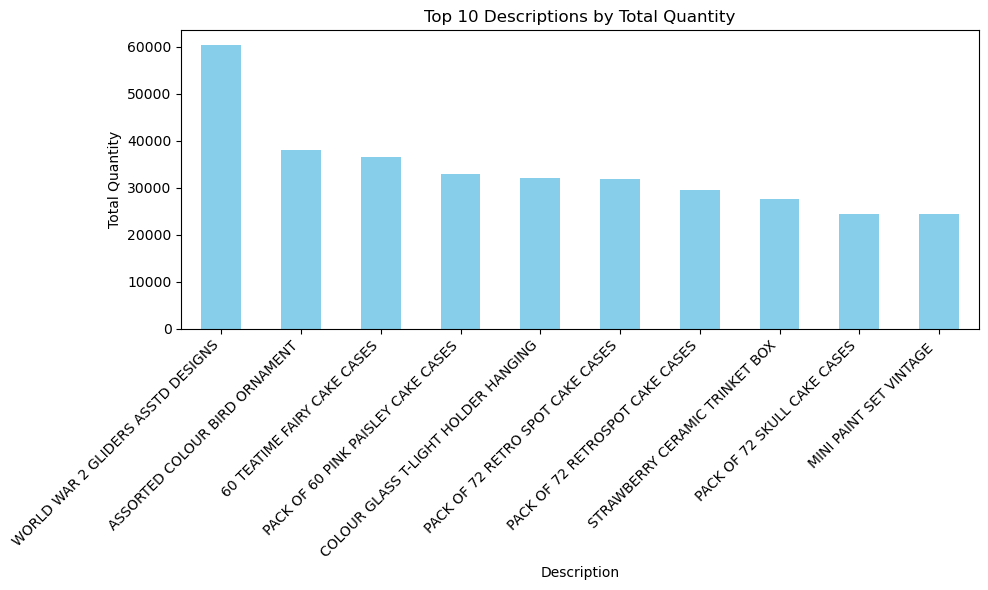

In [30]:
# Description'a göre Quantity'leri toplayıp en çok olan 10 tanesini seçelim
top_10_descriptions = df2.groupby('Description')['Quantity'].sum().nlargest(10)

# Çubuk grafiğini çizelim
plt.figure(figsize=(10, 6))
top_10_descriptions.plot(kind='bar', color='skyblue')

# Grafiği düzenleyelim
plt.xlabel('Description')
plt.ylabel('Total Quantity')
plt.title('Top 10 Descriptions by Total Quantity')
plt.xticks(rotation=45, ha='right')  # Description'ları grafiğin altında döndürün
plt.grid(False)
# Grafiği gösterelim
plt.tight_layout()
plt.show()

/tmp/ipykernel_20/255801573.py:15: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(top_5_countries.index, loc='best', bbox_to_anchor=(1, 0.5), prop={'size': 10}, title='Countries', labels=top_5_countries.index)


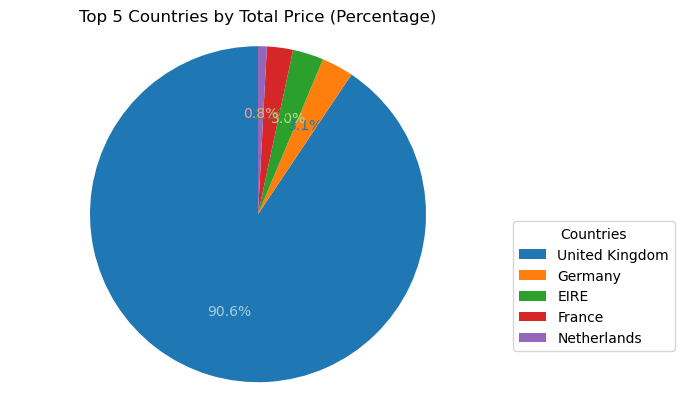

In [31]:
# Country'lere göre Total Priceların toplamını hesaplayalım
total_price_by_country = df2.groupby('Country')['Total Price'].sum()

# Toplam Total Price değerlerini yüzde cinsinden hesaplayalım
total_price_percentages = (total_price_by_country / total_price_by_country.sum()) * 100

# İlk 5 ülkeyi seçelim
top_5_countries = total_price_percentages.nlargest(5)

# Pasta grafiğini çizelim ve renkleri alalım
_, _, autotexts = plt.pie(top_5_countries, labels=None, autopct='%1.1f%%', startangle=90)

# Renkleri elde edin ve legend olarak kullanalım
colors = plt.cm.Paired(range(len(top_5_countries)))
plt.legend(top_5_countries.index, loc='best', bbox_to_anchor=(1, 0.5), prop={'size': 10}, title='Countries', labels=top_5_countries.index)

# Renkleri yüzdelik dilimlerde kullanmak için güncelleyelim
for i, autotext in enumerate(autotexts):
    autotext.set_color(colors[i])

# Grafiği gösterelim
plt.title('Top 5 Countries by Total Price (Percentage)')
plt.axis('equal')
plt.show()


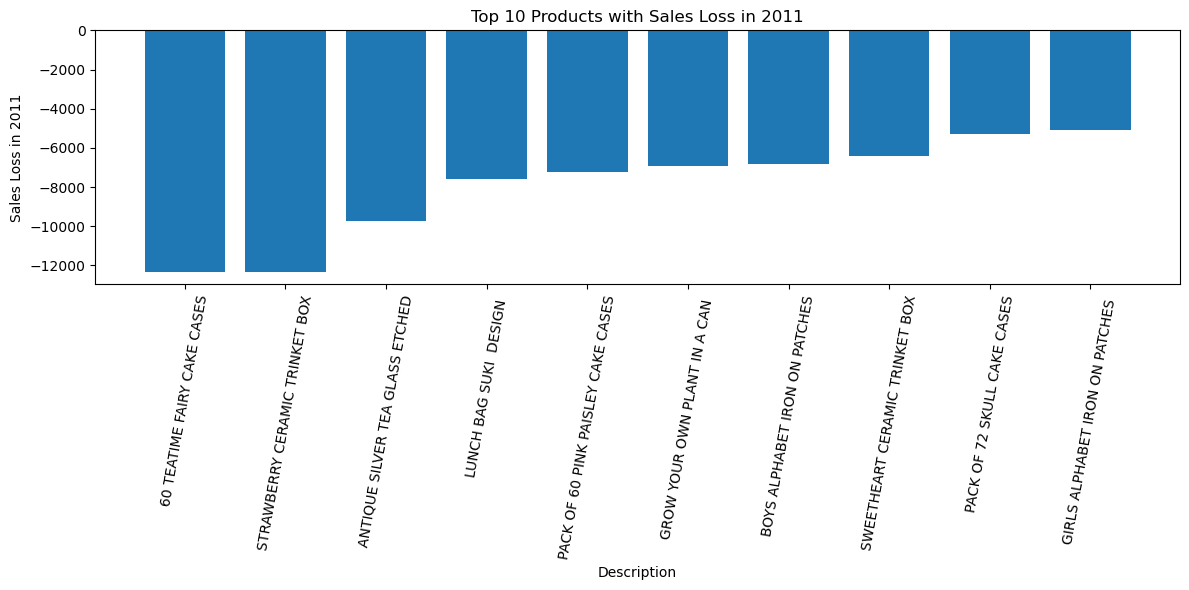

In [32]:
#2010 ve 2011 yıllarındaki toplam miktarları hesaplayalım
total_quantity_2010 = df2[df2['Year'] == 2010].groupby('Description')['Quantity'].sum()
total_quantity_2011 = df2[df2['Year'] == 2011].groupby('Description')['Quantity'].sum()

#2011 yılındaki satış kaybını hesaplayalım
difference = total_quantity_2011 - total_quantity_2010

#Farkı en küçük olan ilk 10 ürünü seçelim
top_10_lost_products = difference.nsmallest(10)

#Grafik oluşturalım
plt.figure(figsize=(12,6))
plt.bar(top_10_lost_products.index, top_10_lost_products.values)
plt.xlabel('Description')
plt.ylabel('Sales Loss in 2011')
plt.title('Top 10 Products with Sales Loss in 2011')
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()


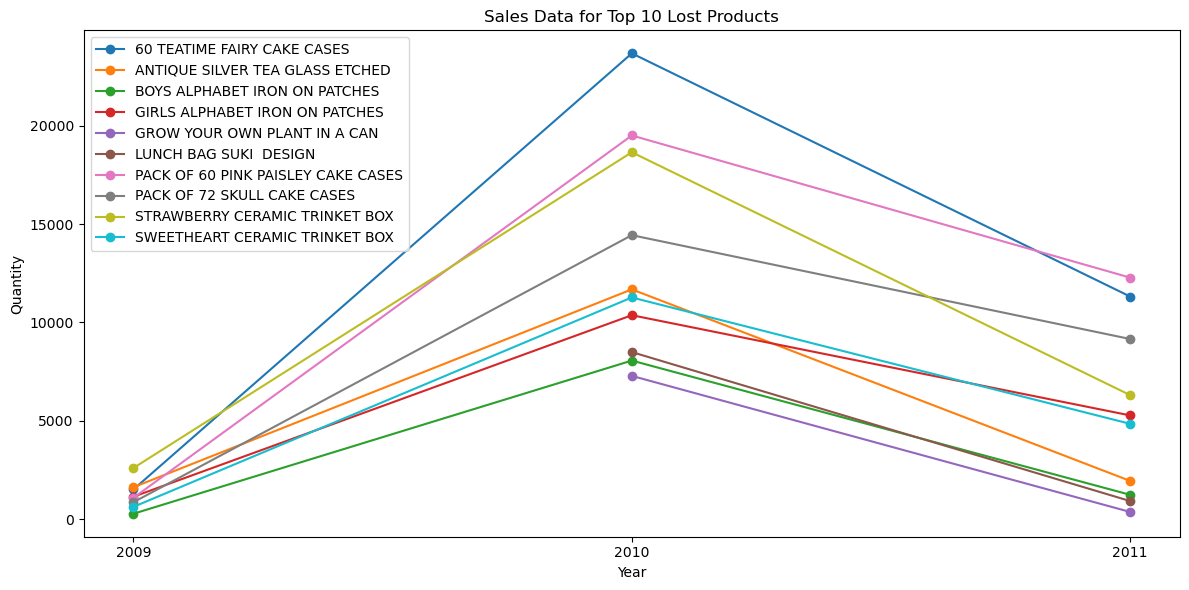

In [33]:
#Seçilen 10 ürünün 2009-2010-2011 yıllarındaki satışlarını elde edelim
selected_products = df2[df2['Description'].isin(top_10_lost_products.index)]
sales_data = selected_products.pivot_table(index='Description', columns='Year', values='Quantity', aggfunc='sum')

# 5. Adım: Çizgi grafiği oluşturalım
plt.figure(figsize=(12, 6))
for product in sales_data.index:
    plt.plot(sales_data.loc[product], marker='o', label=product)

plt.xlabel('Year')
plt.ylabel('Quantity')
plt.title('Sales Data for Top 10 Lost Products')
plt.legend()
plt.xticks([2009, 2010, 2011])
plt.tight_layout()
plt.show()

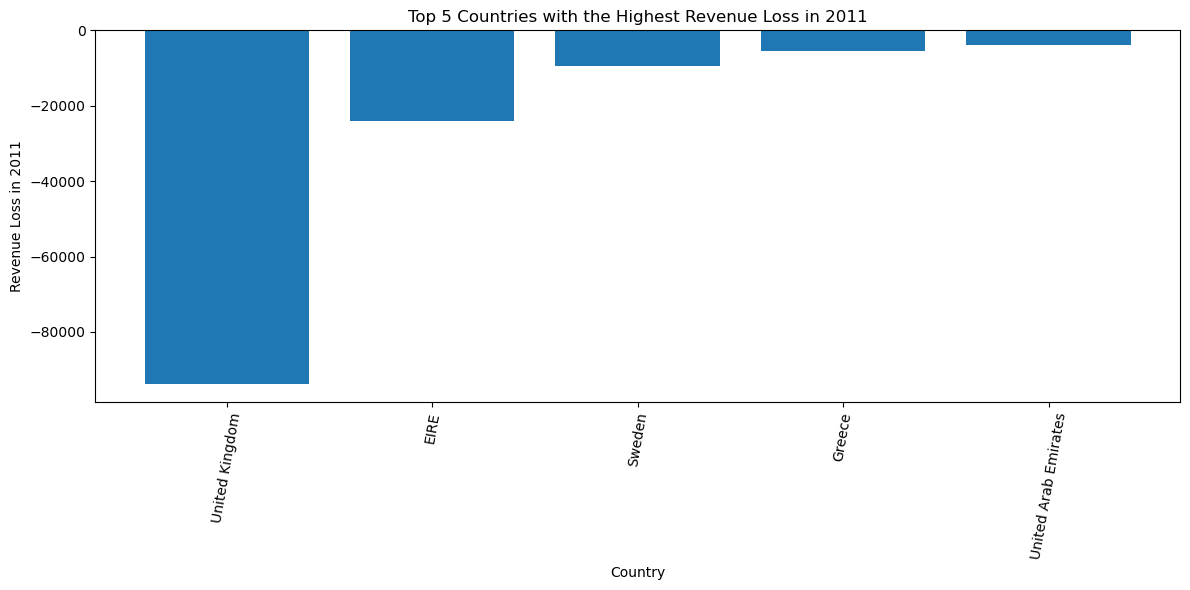

In [34]:
#Ülkelerin satışlarından elde edilen 2010 ve 2011 yıllarındaki toplam ciroları hesaplayalım
total_price_2010 = df2[df2['Year'] == 2010].groupby('Country')['Total Price'].sum()
total_price_2011 = df2[df2['Year'] == 2011].groupby('Country')['Total Price'].sum()

#2011 yılındaki ciro kaybını hesaplayalım
difference = total_price_2011 - total_price_2010

#Farkı en küçük olan ilk 10 ülkeyi seçelim
top_5_lost_revenue = difference.nsmallest(5)

#Grafik oluşturalım
plt.figure(figsize=(12,6))
plt.bar(top_5_lost_revenue.index, top_5_lost_revenue.values)
plt.xlabel('Country')
plt.ylabel('Revenue Loss in 2011')
plt.title('Top 5 Countries with the Highest Revenue Loss in 2011')
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

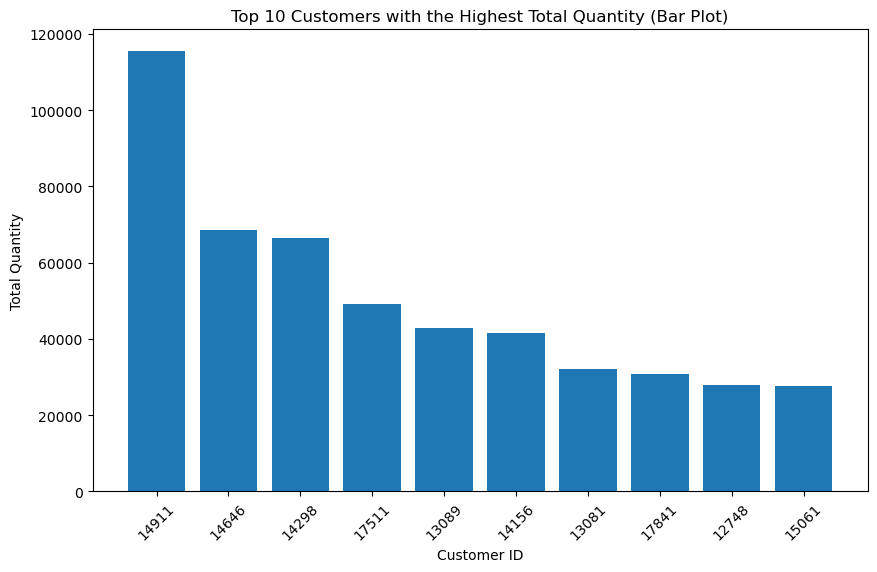

In [35]:
# Her Customer ID'nin toplam Quantity'sini hesaplayalım
total_quantity_by_customer = df2.groupby('Customer ID')['Quantity'].sum()

# En çok toplam Quantity'ye sahip 10 müşteriyi seçelim
top_10_customers = total_quantity_by_customer.nlargest(10)

# Çubuk grafiğini çizelim
plt.figure(figsize=(10, 6))
plt.bar(top_10_customers.index, top_10_customers.values)
plt.xlabel('Customer ID')
plt.ylabel('Total Quantity')
plt.title('Top 10 Customers with the Highest Total Quantity (Bar Plot)')
plt.xticks(rotation=45)
plt.show()

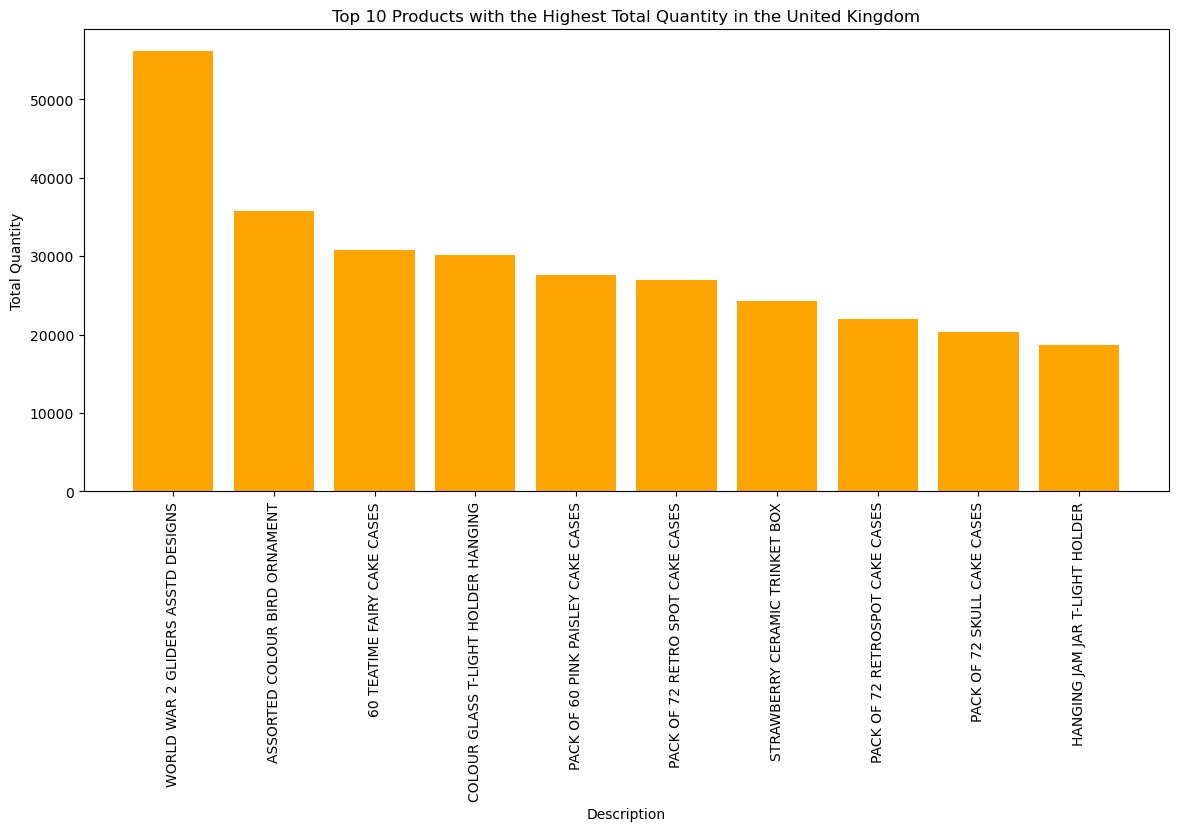

In [36]:
# United Kingdom (UK) ülkesindeki her Description'ın toplam Quantity'sini hesaplayalım
uk_description_quantity = df2[df2['Country'] == 'United Kingdom'].groupby('Description')['Quantity'].sum()

# En fazla toplam Quantity'ye sahip ilk 10 ürünü seçelim
top_10_products = uk_description_quantity.nlargest(10)

# Grafikle gösterelim
plt.figure(figsize=(14, 6))
plt.bar(top_10_products.index, top_10_products.values, color='orange')
plt.xlabel('Description')
plt.ylabel('Total Quantity')
plt.title('Top 10 Products with the Highest Total Quantity in the United Kingdom')
plt.xticks(rotation=90)
plt.show()

In [37]:
df2.head()

,Invoice,StockCode,Description,Quantity,Price,Customer ID,Country,Total Price,Year,Month,Day
0,492744,20717,STRAWBERRY SHOPPER BAG,10,1.25,12422,Australia,12.5,2009,12,18
1,492744,20727,LUNCH BAG BLACK SKULL.,10,1.65,12422,Australia,16.5,2009,12,18
2,492744,20728,LUNCH BAG CARS BLUE,10,1.65,12422,Australia,16.5,2009,12,18
3,492744,20730,STRAWBERRY CANDY BAG,10,1.25,12422,Australia,12.5,2009,12,18
4,489450,21871,SAVE THE PLANET MUG,12,1.25,16321,Australia,15.0,2009,12,1


In [38]:
#Total Price'ı tahmin edilecek model çalıştıralamadı çünkü RAM ve CPU izin vermedi.
# 'REGENCY CAKESTAND 3 TIER' olan verileri seçelim
target_description = 'REGENCY CAKESTAND 3 TIER'
df_target = df2[df2['Description'] == target_description]

# Bağımlı ve bağımsız değişkenleri ayıralım
X = df_target[['Quantity', 'Price','Year']]
y = df_target['Total Price']

# Verileri eğitim ve test veri setleri olarak bölelim
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Lineer regresyon modelini oluşturalım ve eğitelim
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Eğitilen model ile tahminler yapalım
y_pred = regressor.predict(X_test)

# Modelin performansını değerlendirelim
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
# Modelin formülünü ekrana yazdıralım
b0 = regressor.intercept_
b1, b2, b3 = regressor.coef_

print(f"Total Price = {b0:.2f} + {b1:.2f} * Year + {b2:.2f} * Quantity + {b3:.2f} * Price")

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

Total Price = -11.96 + 12.75 * Year + 1.47 * Quantity + -0.00 * Price
Mean Squared Error (MSE): 61.37
R-squared (R2): 0.83


Random Forest Model - Ortalama Kare Hata (MSE): 0.19
Random Forest Model - R-squared (R2) Skoru: 1.00


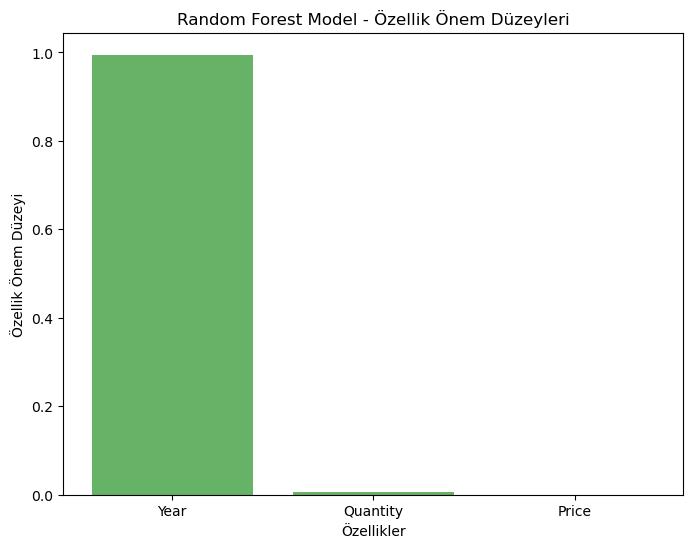

In [39]:
# Random Forest regresyon modelini oluşturalım ve eğitelim
rf_regressor = RandomForestRegressor(random_state=42)
rf_regressor.fit(X, y)

# Özellik önem düzeylerini alalım
feature_importance = rf_regressor.feature_importances_

# R-squared (R2) skorunu alalım
r2_score_rf = rf_regressor.score(X, y)
# Ortalama Kare Hata (MSE) hesaplayalım
y_pred = rf_regressor.predict(X)
mse = mean_squared_error(y, y_pred)
print(f"Random Forest Model - Ortalama Kare Hata (MSE): {mse:.2f}")
# R-squared (R2) skorunu ekrana yazdıralım
print(f"Random Forest Model - R-squared (R2) Skoru: {r2_score_rf:.2f}")

# Özellik önem düzeylerini grafikle görselleştirelim
plt.figure(figsize=(8, 6))
features = ['Year', 'Quantity', 'Price']
plt.bar(features, feature_importance, color='green', alpha=0.6)
plt.xlabel("Özellikler")
plt.ylabel("Özellik Önem Düzeyi")
plt.title("Random Forest Model - Özellik Önem Düzeyleri")
plt.show()
#Bu kodlar, 'REGENCY CAKESTAND 3 TIER' olanın 2012 yılındaki toplam Total Price'ını tahmin etmek için Random Forest regresyon modeli oluşturur ve bu modelin özellik önem düzeylerini belirler. Daha sonra, özellik önem düzeylerini çubuk grafikle görselleştirir.

#Grafikteki çubuklar, "Year", "Quantity" ve "Price" özelliklerinin önem düzeylerini temsil eder. Eğer bir özelliğin çubuğu daha yüksekse, o özellik modelin tahminlerini yaparken daha önemli bir rol oynamış demektir.

#Grafik sayesinde, 'REGENCY CAKESTAND 3 TIER' ürününün 2012 yılındaki toplam Total Price'ını tahmin ederken hangi özelliklerin daha etkili olduğunu görebilirsiniz. Örneğin, "Price" özelliğinin diğerlerine göre daha önemli olduğunu gözlemleyebilirsiniz.


In [40]:
#Zaman Serisi ile Regency Cakestand 3 Tier ürününün 2012 yılının aylık toplam satış tutarlarını tahmin etmek:
    
# 'REGENCY CAKESTAND 3 TIER' olan verileri seçelim
target_description = 'REGENCY CAKESTAND 3 TIER'
df_target = df2[df2['Description'] == target_description]

# 2009, 2010 ve 2011 yıllarındaki verileri seçelim
df_target_years = df_target[(df_target['Year'] >= 2009) & (df_target['Year'] <= 2011)]

# Her yılın aylarındaki toplam Total Price'ları hesaplayalım
df_total_prices = df_target_years.groupby(['Year', 'Month'])['Total Price'].sum().reset_index()

df_total_prices

,Year,Month,Total Price
0,2010,3,2473.50
1,2010,4,4500.75
2,2010,5,2346.00
3,2010,6,5114.70
4,2010,7,4016.25
5,2010,8,3506.25
6,2010,9,5342.25
7,2010,10,6349.50
8,2010,11,5828.70
9,2010,12,3570.00


In [41]:
#Bir Data Frame oluşturalım
data = {
    'ds': pd.to_datetime(df_total_prices[['Year', 'Month']].assign(day=1)),
    'y': df_total_prices['Total Price']
}

df_total_prices = pd.DataFrame(data)

# Prophet modelini oluşturun
model = Prophet()

# Verilere modeli uydurun
model.fit(df_total_prices)

# 2012 yılına ait tahminleri yapmak için gelecek tarihleri oluşturun
future_dates = model.make_future_dataframe(periods=12, freq='MS', include_history=False)

# Uydurulmuş modeli kullanarak 2012 yılına ait tahminleri yapın
forecast = model.predict(future_dates)

# Tahminleri ekrana yazdırın
print(forecast[['ds', 'yhat']])

21:45:46 - cmdstanpy - INFO - Chain [1] start processing
21:45:46 - cmdstanpy - INFO - Chain [1] done processing


           ds         yhat
0  2012-01-01  2886.198709
1  2012-02-01  2820.248948
2  2012-03-01  2758.554009
3  2012-04-01  2692.604247
4  2012-05-01  2628.781897
5  2012-06-01  2562.832135
6  2012-07-01  2499.009785
7  2012-08-01  2433.060023
8  2012-09-01  2367.110261
9  2012-10-01  2303.287911
10 2012-11-01  2237.338149
11 2012-12-01  2173.515799
